# Sequential Linear Regression
### This code takes you through the steps taken to evaluate our linear regression algorithm

- Imports and helper functions (skip this)

- Get in-sample forecast RMSE and PCT errors
    - Plot example in-sample forecast
- Plot example load profiles
- Evaluate speed of learning with various regularization terms
- Plot learning curves
- Get out-of-sample forecasts with various regularization terms
- Plot histograms of accuracies


#### Import Packages, define helper functions (skip over this)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import sklearn.linear_model

E_NAMES = ['Electricity:Facility [kW](Hourly)','Electricity:HVAC [kW](Hourly)','General:InteriorLights:Electricity [kW](Hourly)','General:ExteriorLights:Electricity [kW](Hourly)','Appl:InteriorEquipment:Electricity [kW](Hourly)','Misc:InteriorEquipment:Electricity [kW](Hourly) ']
NEW_E_NAMES = ['Facility','HVAC','Lighting','Exterior','Appliances','Misc']

# Gives the average RMSE of a predicted time series versus it's actual values
def root_mean_squared_error(pred, test):
    return np.sqrt(np.average(np.square(pred - test)))

# Gives the average percent error of a predicted time series versus it's actual values
def percent_error(pred, test):
    return np.average(abs(pred - test) / test)

# Shifts the data from an electricity dataframe backward by n. 
# Retains the time/date information from the unshifted dataframe
def shift_load_array(electricity, n):
    prev_electricity = electricity.tail(n).append(electricity[0:len(electricity)-n])
    prev_electricity.reset_index(inplace = True, drop = True)
    prev_electricity.Hour = electricity.Hour
    prev_electricity.Month = electricity.Month
    prev_electricity.Day = electricity.Day
    return prev_electricity

# Takes a dataframe of electricity loads and returns the array of it's values,
# in the shape of (24 hours, 365 days, 6 load features)
def set_array(electricity):
    loads = np.zeros((24, int(len(electricity)/24), len(E_NAMES)))
    for hour in range(loads.shape[0]):
        loads[hour] = np.asarray(electricity[NEW_E_NAMES][electricity.Hour == hour+1])

    return loads

# Takes a dataframe (like that returned from setup) and returns arrays according to the idea
# that the features to predict for one hour's loads are the loads from the previous hour
# returns an X array and a Y array shifted by one from each other
def set_X_and_Y(electricity):
    prev_electricity = shift_load_array(electricity, 1)
    X = set_array(prev_electricity)
    Y = set_array(electricity)
    return X, Y

# setup loads 'filename' and renames it's columns for easy referencing.
def setup(filename):
    raw = pd.read_csv(filename)
    electricity = pd.DataFrame(columns = ['Month','Day','Hour','Minute','DateTime'] + NEW_E_NAMES)
    electricity[['Facility','HVAC','Lighting','Exterior','Appliances','Misc']] = raw[E_NAMES]
    electricity.Month  = raw['Date/Time'].str[0:3].astype(int)
    electricity.Day    = raw['Date/Time'].str[4:6].astype(int)
    electricity.Hour   = raw['Date/Time'].str[8:10].astype(int)
    electricity.Minute = raw['Date/Time'].str[11:13].astype(int)
    electricity.DateTime = raw['Date/Time']
    return electricity

## Get in-sample forecasts, RMSE and percent errors

In [757]:
electricity = setup('USA_CA_Mountain.View-Moffett.Field.NAS.745090_TMY3_HIGH.csv')
num_test_days = 30
len_test_period = 2 # days
num_train_days = 365 - len_test_period
np.random.seed(0)
test_days = np.random.randint(low = 0, high = len(electricity)/24, size = num_test_days) * 24

MSE = []
PCT = []
for td in test_days:
    adjusted_electricity = electricity[td:len(electricity)].append(electricity[0:td])
    X, Y = set_X_and_Y(adjusted_electricity)
    print('Start time: %s' % adjusted_electricity.DateTime.values[0])
    
    times = adjusted_electricity.tail(len_test_period*24).Hour.values - 1
    
    predictions = []
    real = []
    
    for d in range(len_test_period):
        # Update the training data to include days that have been seen
        X_train = X[:,0:num_train_days+d,:]
        Y_train = Y[:,0:num_train_days+d,:]
        X_test = X[:,num_train_days+d:X.shape[1],:]
        Y_test = Y[:,num_train_days+d:Y.shape[1],:]
        
        for t in range(X_test.shape[0]):
            model = sklearn.linear_model.LinearRegression()
            time = times[t]
            x_train = X_train[time,:,:]
            y_train = Y_train[time,:,0]
            y_train = y_train.reshape((len(y_train), 1))
            model.fit(x_train, y_train)
            next_time = time + 1
            #print(model.score(x_train, y_train))
            if next_time == 24: next_time = 0
            current_load = X_test[time, 0,:]
            expected_load = X_test[next_time, 0, 0]
            prediction = model.predict(current_load.reshape((1, len(current_load))))[0,0]
            predictions.append(prediction)
            real.append(expected_load)
            
    
    MSE.append(mean_squared_error(np.array(predictions), real))
    PCT.append(percent_error(np.array(predictions), real))
    
print('Average MSE: %f, Average Percent Error: %f%%' % (np.average(MSE), np.average(PCT)))
print('STD on MSE: %f, STD on Percent Error: %f%%' % (np.std(MSE), np.std(PCT)))
        
            

Start time:  06/22  01:00:00
Start time:  02/17  01:00:00
Start time:  04/28  01:00:00
Start time:  07/12  01:00:00
Start time:  11/20  01:00:00
Start time:  09/09  01:00:00
Start time:  07/15  01:00:00
Start time:  12/26  01:00:00
Start time:  01/10  01:00:00
Start time:  07/31  01:00:00
Start time:  10/05  01:00:00
Start time:  08/31  01:00:00
Start time:  10/20  01:00:00
Start time:  03/29  01:00:00
Start time:  03/12  01:00:00
Start time:  03/30  01:00:00
Start time:  11/11  01:00:00
Start time:  07/13  01:00:00
Start time:  02/09  01:00:00
Start time:  03/29  01:00:00
Start time:  06/24  01:00:00
Start time:  03/30  01:00:00
Start time:  12/04  01:00:00
Start time:  06/15  01:00:00
Start time:  01/26  01:00:00
Start time:  11/30  01:00:00
Start time:  03/14  01:00:00
Start time:  09/23  01:00:00
Start time:  04/26  01:00:00
Start time:  09/01  01:00:00
Average MSE: 0.000911, Average Percent Error: 0.016067%
STD on MSE: 0.000500, STD on Percent Error: 0.004177%


## Plot example in-sample forecast

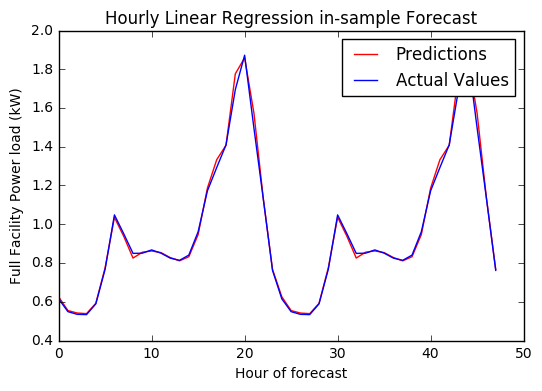

In [759]:
plt.plot(np.arange(len(predictions)), predictions, color = 'red', label = 'Predictions')
plt.plot(np.arange(len(real)), real, color ='blue', label = 'Actual Values')
plt.title('Hourly Linear Regression in-sample Forecast')
plt.xlabel('Hour of forecast')
plt.ylabel('Full Facility Power load (kW)')
plt.legend()
plt.show()

## Plot example load profiles
- Important for readers to understand the basic structure of our data

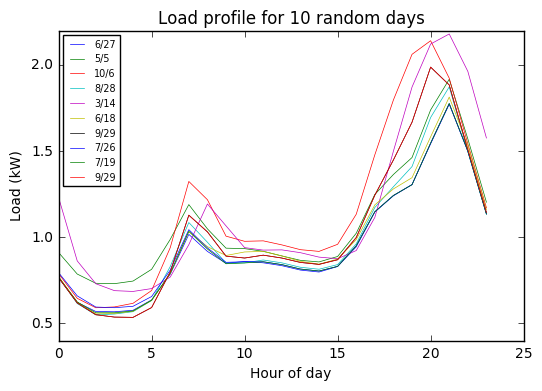

In [904]:
# Simply plotting examples of daily cycles
hours = np.arange(24)
days = np.random.randint(364, size = 10)
for d in days:
    plt.plot(hours, X[:,d,0], linewidth = 0.5, label = '%d/%d' % (electricity.Month.values[d*24], electricity.Day.values[d*24]))
plt.title('Load profile for 10 random days')
plt.legend(loc = 'best', fontsize = 'x-small')
plt.xlabel('Hour of day')
plt.ylabel('Load (kW)')
plt.show()

## Determine the speed of learning from the model
- Incrementally: 
    - adds days to the training set 
    - trains the linear regression
    - evaluates predictions on remainder of data
    - plots learning curves

1e-08
1e-06
1e-05
0.0001
0.01
0.1


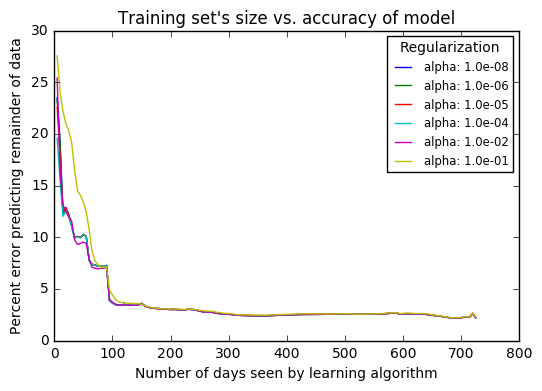

In [13]:
electricity = setup('USA_CA_Mountain.View-Moffett.Field.NAS.745090_TMY3_HIGH.csv')
td = 0
electricity = electricity[td:len(electricity)].append(electricity[0:td])

# Add a second year to the training data, with a small amount of Gaussian noise (std = 0.01)
## This way, the model we get at the end of the year still has data to predict
second_year = electricity
second_year[NEW_E_NAMES] = electricity[NEW_E_NAMES].values + np.random.normal(size = electricity[NEW_E_NAMES].values.shape, scale = 0.01)
electricity = electricity.append(second_year).reset_index(drop=True)

alphas = [10e-9, 10e-7,10e-6, 10e-5, 10e-3, 10e-2]
for a in alphas:
    print(a)
    scores = []
    test_sizes = np.arange(5,364*2, 5)
    train_sizes = 365*2 - test_sizes
    for num_test_days in test_sizes:
        num_train_days = 365*2 - num_test_days

        X, Y = set_X_and_Y(electricity)
        X_train = X[:,0:num_train_days,:]
        Y_train = Y[:,0:num_train_days,0]
        X_test = X[:,num_train_days:X.shape[1],:]
        Y_test = Y[:,num_train_days:Y.shape[1],0]

        models = []
        pred = []
        reals = []
        for t in range(24):
            x_train = X_train[t]
            y_train = Y_train[t]
            model = sklearn.linear_model.Ridge(a)
            model.fit(x_train, y_train)
            models.append(model)
            x_test = X_test[t]
            y_test = Y_test[t]
            predictions = model.predict(x_test)
            pred.append(predictions)
            real_values = y_test
            reals.append(real_values)

        pred = np.array(pred)
        reals = np.array(reals)
        rmse = root_mean_squared_error(pred, reals)
        pct = percent_error(pred, reals)
        scores.append([rmse, pct])
    scores = np.array(scores)
    plt.plot(train_sizes,scores[:,1]*100, label = 'alpha: %.1e' % a)
plt.legend(title = 'Regularization', fontsize = 'small')
plt.title('Training set\'s size vs. accuracy of model')
plt.xlabel('Number of days seen by learning algorithm')
plt.ylabel('Percent error predicting remainder of data')
plt.show()

In [10]:
Y_test[t].shape

(5,)

#### Appendix: Helper functions

In [934]:
# Make for easy setup of Pandas dataframes
E_NAMES = ['Electricity:Facility [kW](Hourly)','Electricity:HVAC [kW](Hourly)','General:InteriorLights:Electricity [kW](Hourly)','General:ExteriorLights:Electricity [kW](Hourly)','Appl:InteriorEquipment:Electricity [kW](Hourly)','Misc:InteriorEquipment:Electricity [kW](Hourly) ']
NEW_E_NAMES = ['Facility','HVAC','Lighting','Exterior','Appliances','Misc']

# Gives the average RMSE of a predicted time series versus it's actual values
def root_mean_squared_error(pred, test):
    return np.sqrt(np.average(np.square(pred - test)))

# Gives the average percent error of a predicted time series versus it's actual values
def percent_error(pred, test):
    return np.average(abs(pred - test) / test)

# Shifts the data from an electricity dataframe backward by n. 
# Retains the time/date information from the unshifted dataframe
def shift_load_array(electricity, n):
    prev_electricity = electricity.tail(n).append(electricity[0:len(electricity)-n])
    prev_electricity.reset_index(inplace = True, drop = True)
    prev_electricity.Hour = electricity.Hour
    prev_electricity.Month = electricity.Month
    prev_electricity.Day = electricity.Day
    return prev_electricity

# Takes a dataframe of electricity loads and returns the array of it's values,
# in the shape of (24 hours, 365 days, 6 load features)
def set_array(electricity):
    loads = np.zeros((24, int(len(electricity)/24), len(E_NAMES)))
    for hour in range(loads.shape[0]):
        loads[hour] = np.asarray(electricity[NEW_E_NAMES][electricity.Hour == hour+1])

    return loads

# Takes a dataframe (like that returned from setup) and returns arrays according to the idea
# that the features to predict for one hour's loads are the loads from the previous hour
# returns an X array and a Y array shifted by one from each other
def set_X_and_Y(electricity):
    prev_electricity = shift_load_array(electricity, 1)
    X = set_array(prev_electricity)
    Y = set_array(electricity)
    return X, Y

# setup loads 'filename' and renames it's columns for easy referencing.
def setup(filename):
    raw = pd.read_csv(filename)
    electricity = pd.DataFrame(columns = ['Month','Day','Hour','Minute','DateTime'] + NEW_E_NAMES)
    electricity[['Facility','HVAC','Lighting','Exterior','Appliances','Misc']] = raw[E_NAMES]
    electricity.Month  = raw['Date/Time'].str[0:3].astype(int)
    electricity.Day    = raw['Date/Time'].str[4:6].astype(int)
    electricity.Hour   = raw['Date/Time'].str[8:10].astype(int)
    electricity.Minute = raw['Date/Time'].str[11:13].astype(int)
    electricity.DateTime = raw['Date/Time']
    return electricity

## Out-of-sample forecasting
- In separate interations: 
    - makes each individual day the test day 
    - trains the model on the rest of the days
    - performs an out-of-sample forecast on the final day
    - evaluates the prediction
    - stores the RMSE and percent error

In [15]:
electricity = setup('USA_CA_Mountain.View-Moffett.Field.NAS.745090_TMY3_HIGH.csv')
test_days = np.arange(364) * 24
alphas = [10e-13, 10e-11, 10e-9, 10e-7,10e-6, 10e-5, 10e-3, 10e-2, 0]
fcs = []
rlz = []
scrs = []
for a in alphas:
    print(a)
    scores = []

    for td in test_days:
        electricity = electricity[td:len(electricity)].append(electricity[0:td])

        num_test_days = 1
        num_train_days = 365 - num_test_days

        X, Y = set_X_and_Y(electricity)
        X_train = X[:,0:num_train_days,:]
        Y_train = Y[:,0:num_train_days,:]
        X_test = X[:,num_train_days:X.shape[1],:]
        Y_test = Y[:,num_train_days:Y.shape[1],:]

        models = []
        pred = []
        
        start_hour = 0
        forecast = [X_test[start_hour]]
        reals = [X_test[start_hour]]

        for t in range(start_hour,24):
            x_train = X_train[t]
            y_train = Y_train[t]
            model = sklearn.linear_model.Ridge(a)
            model.fit(x_train, y_train)
            models.append(model)
            x_test = X_test[t]
            y_test = Y_test[t]
            prior_prediction = forecast[len(forecast) - 1]
            predictions = model.predict(prior_prediction)
            forecast.append(predictions)
            real_values = y_test
            reals.append(real_values)

        forecast = np.array(forecast)
        reals = np.array(reals)
        rmse = root_mean_squared_error(forecast[:,0,0], reals[:,0,0])
        pct = percent_error(forecast[:,0,0], reals[:,0,0])
        scores.append([rmse, pct])
    fcs.append(forecast)
    rlz.append(reals)
    scrs.append(scores)
        

1e-12
1e-10
1e-08
1e-06
1e-05
0.0001
0.01
0.1
0


In [16]:
np.average(np.array(scrs), axis = 1)

array([[ 0.11750467,  0.07031026],
       [ 0.11641544,  0.07019951],
       [ 0.11632892,  0.07033132],
       [ 0.11197412,  0.06609496],
       [ 0.11502268,  0.06848586],
       [ 0.11466931,  0.06636094],
       [ 0.10818497,  0.06375817],
       [ 0.12289851,  0.07066476],
       [ 0.1580081 ,  0.08493559]])

In [17]:
np.std(np.array(scrs), axis = 1)

array([[ 0.04832126,  0.04440426],
       [ 0.04903048,  0.04257523],
       [ 0.05369766,  0.0446769 ],
       [ 0.04800259,  0.03827043],
       [ 0.04989968,  0.0420938 ],
       [ 0.05300097,  0.04006176],
       [ 0.04187673,  0.02998735],
       [ 0.04057467,  0.0284417 ],
       [ 0.17170025,  0.0837834 ]])

The best forecast is the 7th one, or using 10e-3 as the regularization term

In [1171]:
np.array(rlz)[6].shape

(25, 1, 6)

## Plotting an example of out-of-sample forecast from the best-performing regularization term

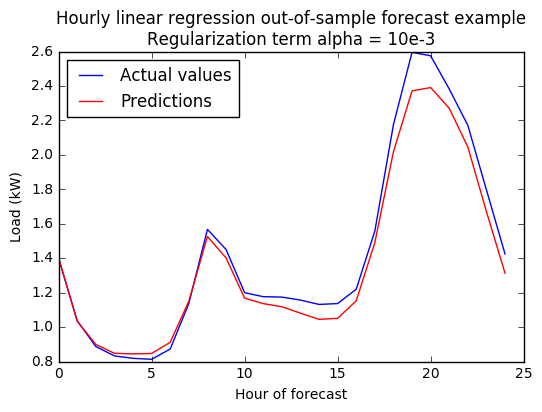

In [1172]:
day = 6
hours = np.arange(forecast.shape[0])
day = np.random.randint(len(rlz))
plt.plot(hours, rlz[day][:,0,0], label = 'Actual values')
plt.plot(hours, fcs[day][:,0,0], label = 'Predictions', color='red')
plt.legend(loc = 'best')
plt.xlabel('Hour of forecast')
plt.ylabel('Load (kW)')
plt.title('Hourly linear regression out-of-sample forecast example\nRegularization term alpha = 10e-3')
plt.show()



#### Ways to display accuracy data
- boxplot
- histogram

### Plot the accuracy distributions of each Ridge Regression

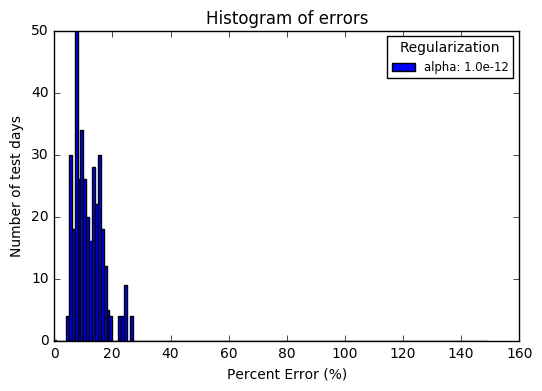

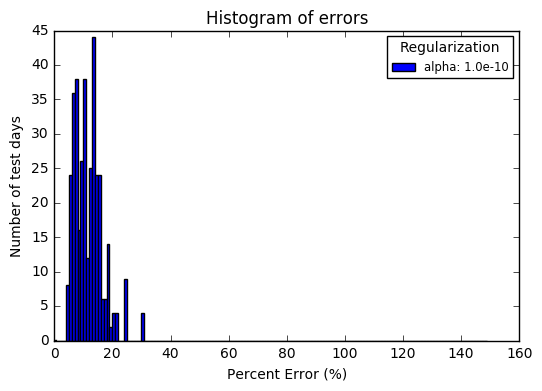

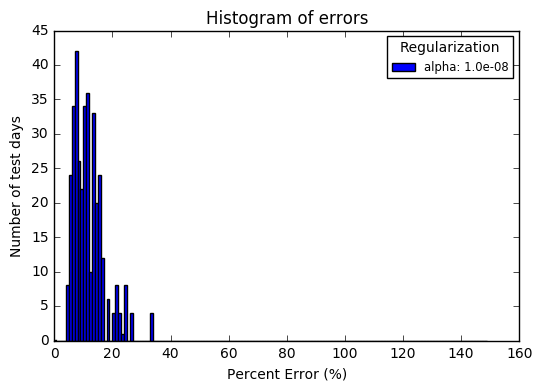

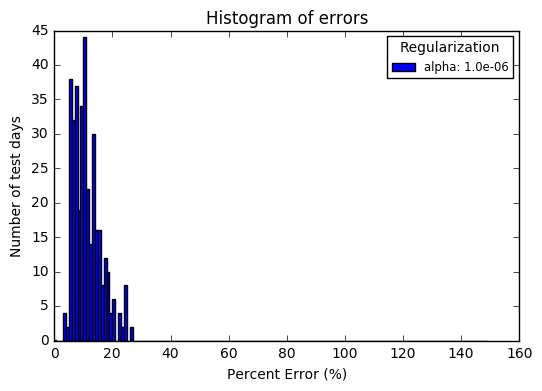

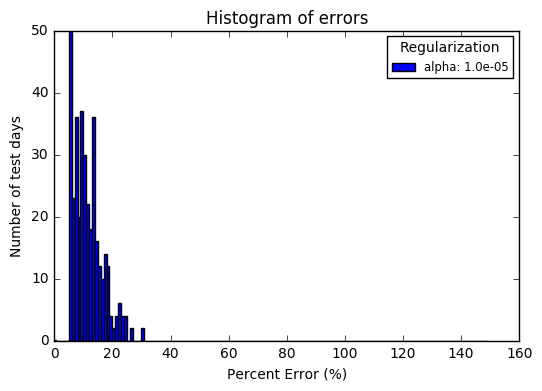

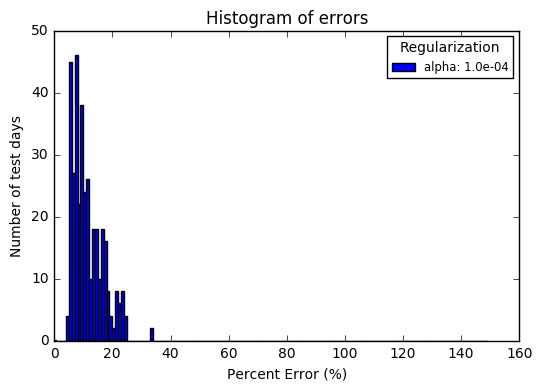

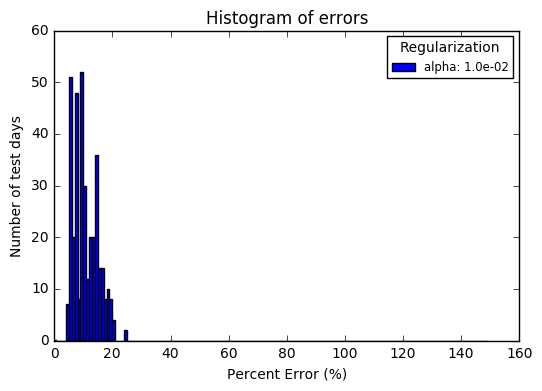

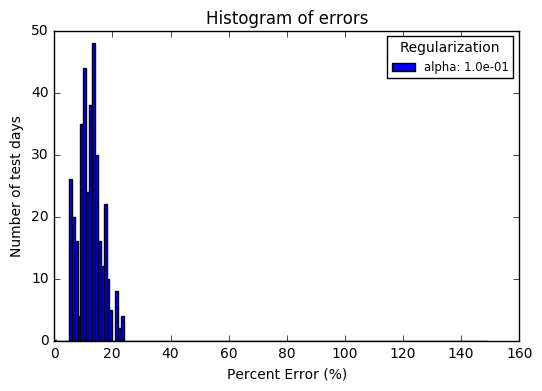

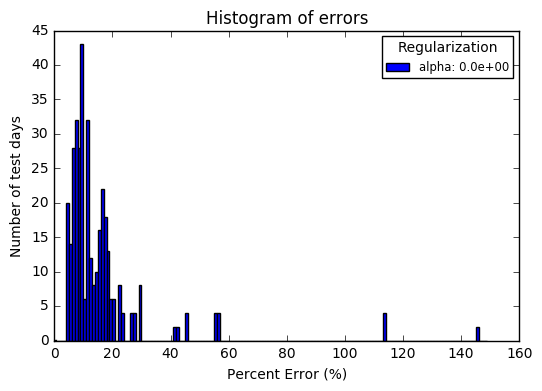

In [18]:
for a in range(len(alphas)):
    plt.hist(np.array(scrs)[a,:,0] * 100, bins = np.arange(0,150, step = 1), label = 'alpha: %.1e' % alphas[a])
    plt.legend(loc='best',title = 'Regularization', fontsize = 'small')
    plt.xlabel('Percent Error (%)')
    plt.ylabel('Number of test days')
    plt.title('Histogram of errors')
    plt.show()


## Boxplot of accuracies

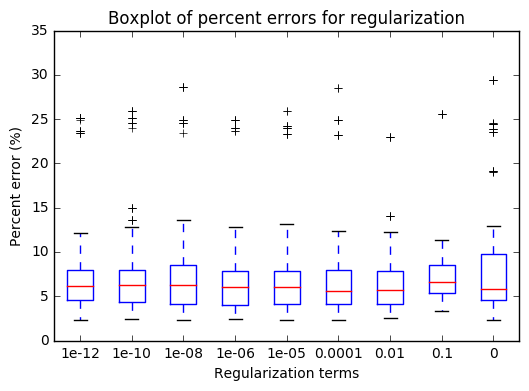

In [21]:
pcts = np.array(scrs)[:,:,1].T

plt.boxplot(pcts*100, labels = alphas)
plt.ylim([0, 35])
plt.ylabel('Percent error (%)')
plt.xlabel('Regularization terms')
plt.title('Boxplot of percent errors for regularization')
plt.show()